In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import BaseMessage, HumanMessage
from src.agents import create_agent



In [ ]:
thread_config = {"configurable": {"thread_id": "deep-research-thread-11thronee1"}}

query = """
Do a deep research on agentech in oklahoma city. you should use the web. Agentech is a new startup in the Insurance Claims space. You need to find out the following:
this is their url: https://www.agentech.com/
1. Who are the founders of the company?
2. What is the funding status of the company?
3. What are the recent news articles about the company?
4. What are the competitors of the company?
5. What are the recent job postings for the company?
"""

initial_input = {"messages": [HumanMessage(content=query)]}

result = agent.invoke(initial_input, config=thread_config)

In [ ]:
result

In [ ]:
# The final output structure might vary, adjust this key if needed.
if result.get('messages') and isinstance(result['messages'], list) and len(result['messages']) > 1:
        final_report_content = result['messages'][-1].content
        # Assuming the report is in the content of the last message
        print("\n--- FINAL REPORT ---")
        print(final_report_content)
else:
        print("Could not find final report in the result.")
        print(result)


In [ ]:
from src.agents.agent import deep_agent

In [1]:
import os
from typing import Literal

from tavily import TavilyClient
from src.agents.agent import deep_agent
from typing import Any, Callable, List, Optional, cast, Dict, Literal, Union
import os 
from pydantic import BaseModel, Field
from dotenv import load_dotenv
# It's best practice to initialize the client once and reuse it.
tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

# # Search tool to use to do research
# def internet_search(
#     query: str,
#     max_results: int = 5,
#     topic: Literal["general", "news", "finance"] = "general",
#     include_raw_content: bool = False,
# ):
#     """Run a web search"""
#     search_docs = tavily_client.search(
#         query,
#         max_results=max_results,
#         include_raw_content=include_raw_content,
#         topic=topic,
#     )
#     return search_docs


from langchain_tavily import TavilySearch
from langchain_core.tools.structured import StructuredTool

# Load environment variables from a .env file for local development.
load_dotenv()

# --- Pydantic Input Schema for Robust Validation ---
class TavilySearchInput(BaseModel):
    """Input schema for the Tavily Search tool."""
    query: str = Field(..., description="The search query to look up.")
    max_results: Optional[int] = Field(
        default=5, description="The maximum number of search results to return."
    )
    search_depth: Optional[Literal["basic", "advanced"]] = Field(
        default="advanced", description="The depth of the search: 'basic' or 'advanced'."
    )
    topic: Optional[Literal["general", "news", "finance"]] = Field(
        default="general", description="The topic for the search."
    )
    include_domains: Optional[List[str]] = Field(
        default=None, description="A list of domains to specifically include in the search."
    )
    exclude_domains: Optional[List[str]] = Field(
        default=None, description="A list of domains to specifically exclude from the search."
    )


class TavilySearchTool:
    """
    A robust, production-ready tool for performing web searches with Tavily.

    This class encapsulates the logic for the search tool, using Pydantic for
    input validation and providing a secure way to handle API keys for both
    local development and production deployment.
    """
    def __init__(self, api_key: Optional[str] = None):
        """
        Initializes the tool and securely configures the API key.
        """
        self.api_key = api_key or os.getenv("TAVILY_API_KEY")
        if not self.api_key:
            raise ValueError(
                "Tavily API key not provided. Please pass it to the constructor "
                "or set the TAVILY_API_KEY environment variable."
            )
        # Instantiate the TavilySearch tool from the correct package once.
        self.tool = TavilySearch(tavily_api_key=self.api_key)


    def run(self, **kwargs) -> List[Dict[str, Any]]:
        """
        Executes the Tavily search with validated input.

        This method is designed to be wrapped by a LangChain StructuredTool.
        It takes keyword arguments that are validated by the Pydantic schema.
        """
        try:
            # Validate the input using the Pydantic model
            validated_args = TavilySearchInput(**kwargs)

            # Convert the Pydantic model to a dictionary for invocation.
            # exclude_none=True ensures we don't pass optional args if they weren't provided.
            invoke_args = validated_args.model_dump(exclude_none=True)

            # Perform the search using the validated arguments
            result = self.tool.invoke(invoke_args)
            return result
        except Exception as e:
            # Return a structured error message if something goes wrong
            return [{"error": f"An error occurred during the search: {e}"}]

# --- Create a default instance and a StructuredTool ---

# 1. Instantiate our production-ready class.
default_tavily_instance = TavilySearchTool()

# 2. Create a StructuredTool from the class method.
internet_search = StructuredTool.from_function(
    name="internet_search",
    func=default_tavily_instance.run,
    description=(
        "A search engine optimized for comprehensive, accurate, and trusted results. "
        "Use this for any general web search, research, or to find current events."
    ),
    args_schema=TavilySearchInput
)


sub_research_prompt = """You are a dedicated researcher. Your job is to conduct research based on the users questions.

Conduct thorough research and then reply to the user with a detailed answer to their question

only your FINAL answer will be passed on to the user. They will have NO knowledge of anything except your final message, so your final report should be your final message!"""

research_sub_agent = {
    "name": "research-agent",
    "description": "Used to research more in depth questions. Only give this researcher one topic at a time. Do not pass multiple sub questions to this researcher. Instead, you should break down a large topic into the necessary components, and then call multiple research agents in parallel, one for each sub question.",
    "prompt": sub_research_prompt,
    "tools": [internet_search],
}

sub_critique_prompt = """You are a dedicated editor. You are being tasked to critique a report.

You can find the report at `final_report.md`.

You can find the question/topic for this report at `question.txt`.

The user may ask for specific areas to critique the report in. Respond to the user with a detailed critique of the report. Things that could be improved.

You can use the search tool to search for information, if that will help you critique the report

Do not write to the `final_report.md` yourself.

Things to check:
- Check that each section is appropriately named
- Check that the report is written as you would find in an essay or a textbook - it should be text heavy, do not let it just be a list of bullet points!
- Check that the report is comprehensive. If any paragraphs or sections are short, or missing important details, point it out.
- Check that the article covers key areas of the industry, ensures overall understanding, and does not omit important parts.
- Check that the article deeply analyzes causes, impacts, and trends, providing valuable insights
- Check that the article closely follows the research topic and directly answers questions
- Check that the article has a clear structure, fluent language, and is easy to understand.
"""

critique_sub_agent = {
    "name": "critique-agent",
    "description": "Used to critique the final report. Give this agent some information about how you want it to critique the report.",
    "prompt": sub_critique_prompt,
}



# Prompt prefix to steer the agent to be an expert researcher
research_instructions = """You are an expert researcher. Your job is to conduct thorough research, and then write a polished report.

The first thing you should do is to write the original user question to `question.txt` so you have a record of it.

Use the research-agent to conduct deep research. It will respond to your questions/topics with a detailed answer.

When you think you enough information to write a final report, write it to `final_report.md`

You can call the critique-agent to get a critique of the final report. After that (if needed) you can do more research and edit the `final_report.md`
You can do this however many times you want until are you satisfied with the result.

Only edit the file once at a time (if you call this tool in parallel, there may be conflicts).

Here are instructions for writing the final report:

<report_instructions>

CRITICAL: Make sure the answer is written in the same language as the human messages! If you make a todo plan - you should note in the plan what language the report should be in so you dont forget!
Note: the language the report should be in is the language the QUESTION is in, not the language/country that the question is ABOUT.

Please create a detailed answer to the overall research brief that:
1. Is well-organized with proper headings (# for title, ## for sections, ### for subsections)
2. Includes specific facts and insights from the research
3. References relevant sources using [Title](URL) format
4. Provides a balanced, thorough analysis. Be as comprehensive as possible, and include all information that is relevant to the overall research question. People are using you for deep research and will expect detailed, comprehensive answers.
5. Includes a "Sources" section at the end with all referenced links

You can structure your report in a number of different ways. Here are some examples:

To answer a question that asks you to compare two things, you might structure your report like this:
1/ intro
2/ overview of topic A
3/ overview of topic B
4/ comparison between A and B
5/ conclusion

To answer a question that asks you to return a list of things, you might only need a single section which is the entire list.
1/ list of things or table of things
Or, you could choose to make each item in the list a separate section in the report. When asked for lists, you don't need an introduction or conclusion.
1/ item 1
2/ item 2
3/ item 3

To answer a question that asks you to summarize a topic, give a report, or give an overview, you might structure your report like this:
1/ overview of topic
2/ concept 1
3/ concept 2
4/ concept 3
5/ conclusion

If you think you can answer the question with a single section, you can do that too!
1/ answer

REMEMBER: Section is a VERY fluid and loose concept. You can structure your report however you think is best, including in ways that are not listed above!
Make sure that your sections are cohesive, and make sense for the reader.

For each section of the report, do the following:
- Use simple, clear language
- Use ## for section title (Markdown format) for each section of the report
- Do NOT ever refer to yourself as the writer of the report. This should be a professional report without any self-referential language. 
- Do not say what you are doing in the report. Just write the report without any commentary from yourself.
- Each section should be as long as necessary to deeply answer the question with the information you have gathered. It is expected that sections will be fairly long and verbose. You are writing a deep research report, and users will expect a thorough answer.
- Use bullet points to list out information when appropriate, but by default, write in paragraph form.

REMEMBER:
The brief and research may be in English, but you need to translate this information to the right language when writing the final answer.
Make sure the final answer report is in the SAME language as the human messages in the message history.

Format the report in clear markdown with proper structure and include source references where appropriate.

<Citation Rules>
- Assign each unique URL a single citation number in your text
- End with ### Sources that lists each source with corresponding numbers
- IMPORTANT: Number sources sequentially without gaps (1,2,3,4...) in the final list regardless of which sources you choose
- Each source should be a separate line item in a list, so that in markdown it is rendered as a list.
- Example format:
  [1] Source Title: URL
  [2] Source Title: URL
- Citations are extremely important. Make sure to include these, and pay a lot of attention to getting these right. Users will often use these citations to look into more information.
</Citation Rules>
</report_instructions>

You have access to a few tools.

## `internet_search`

Use this to run an internet search for a given query. You can specify the number of results, the topic, and whether raw content should be included.
"""

# Create the agent
agent = deep_agent(
    agent_name="coder",
    agent_type="coder",
    tools=[internet_search],
    prompt_template=research_instructions,
    sub_research_prompt=sub_research_prompt,
    sub_critique_prompt=sub_critique_prompt,
    sub_query_optimizer_prompt = "",
    sub_insight_extractor_prompt = "",
    sub_followup_prompt = "",
    sub_evidence_auditor_prompt = "",
).with_config({"recursion_limit": 1000})


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\pault\anaconda3\envs\app_project\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\pault\anaconda3\envs\app_project\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\pault\anaconda3\envs\app_project\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.sta

In [2]:
from langchain_openai import ChatOpenAI
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import BaseMessage, HumanMessage
from src.agents.agents.utils.runtime import Runtime
from langgraph.store.memory import InMemoryStore

# from langfuse.langchain import CallbackHandler

# thread_config = {"configurable": {"thread_id": "deep-research-thread-1011-dvsvsth23"},
#                  "callbacks": [CallbackHandler()]}
store = InMemoryStore()
runtime = Runtime(store=store)

thread_config = {"configurable": {"thread_id": "deep-research-thread-1011-oabinna"}
                 }

query = """
Do a deep research on agentech in oklahoma city. you should use the web. Agentech is a new startup in the Insurance Claims space. You need to find out the following:
this is their url: https://www.agentech.com/
1. Who are the founders of the company?
2. What is the funding status of the company?
3. What are the recent news articles about the company?
4. What are the competitors of the company?
5. What are the recent job postings for the company?
"""

# query = """
# Draft a market brief on European battery-recycling startups, including leading players and regulatory headwinds.

# European Battery-Recycling Startups Market Brief
# To draft a comprehensive market brief on European battery-recycling startups, I need to gather detailed information on leading startups, specific regulatory frameworks and their impact, market dynamics, and key challenges and opportunities within the European context. The provided background information offers a starting point for market size and general trends but lacks specific details on European startups and granular regulatory headwinds.

# Identify and Profile Leading European Battery-Recycling Startups

# Research and identify prominent European startups focused on lithium-ion battery recycling. For each identified startup, collect detailed information on their business model, technology (e.g., hydrometallurgical, pyrometallurgical, direct recycling), funding rounds, key investors, operational scale, strategic partnerships, and their specific value proposition in the European market.

# Analyze European Regulatory Landscape and Headwinds for Battery Recycling

# Gather comprehensive details on current and upcoming European regulations, directives, and policies impacting battery recycling, such as the EU Battery Regulation. Specifically, identify regulatory requirements related to collection targets, recycling efficiency rates, recycled content mandates, extended producer responsibility (EPR), and hazardous waste management. Analyze how these regulations create both opportunities and 'headwinds' or challenges for European battery recycling startups.

# Investigate Market Dynamics and Investment Trends in European Battery Recycling

# Collect data on the overall market dynamics within the European battery recycling sector, including market size projections, growth drivers, competitive landscape (beyond just startups, to understand the broader context), and supply chain considerations. Research recent investment trends, venture capital funding, and government grants specifically targeting battery recycling startups in Europe.

# Examine Technological Innovations and Economic Viability Challenges for Startups

# Research the latest technological innovations and advancements being developed or employed by European battery recycling startups. Additionally, investigate the economic viability challenges faced by these startups, including capital expenditure requirements, operational costs, profitability, and the ability to scale their technologies and operations efficiently.

# Identify Key Challenges and Opportunities for European Battery Recycling Startups

# Gather information on a broad range of challenges and opportunities for European battery recycling startups, including but not limited to, feedstock availability, logistics, material purity requirements, competition from established players, global market influences, and the potential for new revenue streams or business models.
# """

initial_input = {"messages": [HumanMessage(content=query)]}

output = agent.invoke(initial_input, config=thread_config, context=runtime)

In [ ]:
output

In [ ]:
print(output["messages"][-1].content)

In [ ]:
print(output['files']['final_report.md'])

In [ ]:
print(output['messages'][-1].content)

In [ ]:
    input_ = {
        "messages": [
            HumanMessage(
                f"# Research Requirements\n\n## Task\n\n{current_plan.title}\n\n## Description\n\n{current_plan.thought}"
            )
        ],
        "locale": state.get("locale", "en-US"),
    }
    invoke_messages = apply_prompt_template("reporter", input_, configurable)

> Visualize the Graph

In [1]:
from src.graph.builder import graph


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\pault\anaconda3\envs\app_project\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\pault\anaconda3\envs\app_project\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\pault\anaconda3\envs\app_project\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.sta

In [ ]:


#-------------------------Using Mermaid.Ink--------------------------------
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

#-------------------------Using Mermaid + Pyppeteer--------------------------------
import nest_asyncio
nest_asyncio.apply()
# %pip install --quiet pyppeteer
# %pip install --quiet nest_asyncio


display(
    Image(
        graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.API,
            background_color="white",
            padding=10,
        )
    )
)

# display(Image(graph.get_graph().draw_png()))

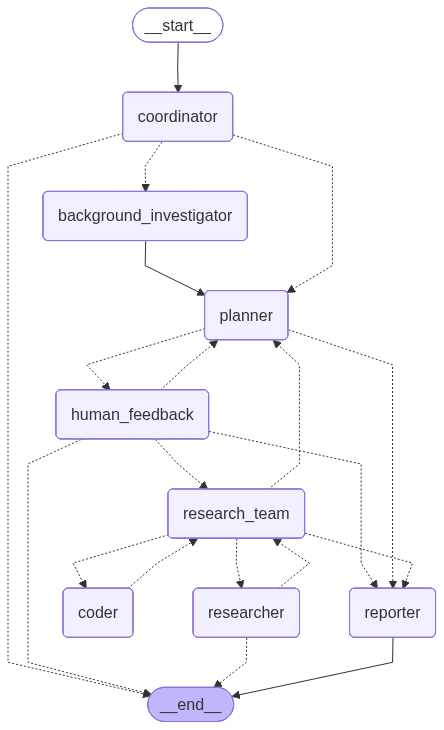

In [4]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [6]:
from langgraph.graph import State

ImportError: cannot import name 'State' from 'langgraph.graph' (c:\Users\pault\anaconda3\envs\app_project\Lib\site-packages\langgraph\graph\__init__.py)

In [3]:
runnable_config["configurable"]

{'max_plan_iterations': 2}

In [ ]:
import asyncio
import uuid
from pprint import pprint
from src.graph.builder import build_graph_with_memory
from langgraph.graph.state import StateGraph
from langchain_core.runnables.config import RunnableConfig
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import InMemorySaver

async def main():
    """
    An asynchronous main function to run the langgraph workflow.
    """
    # Initialize in-memory store for persistence
    store = InMemoryStore()

    # Build the graph with memory (this is your agent's graph)
    # This graph contains async nodes, so we must use the async API.
    graph = build_graph_with_memory()

    # Define the initial input for the workflow
    initial_input = {
        "messages": [HumanMessage(content="Develop a 3-month marketing plan for a new AI-powered gardening app. Don't ask for human feedback, simply proceed to the researcher node.")],
        "plan_iterations": 0,
    }
    thread_id = str(uuid.uuid4())  # Generate a unique thread_id for this session
    # Define the configuration for this run
    runnable_config = RunnableConfig(configurable={"max_plan_iterations": 2,
                                                  "thread_id": thread_id})

    # --- NEW: Add a thread_id for stateful resumption ---
    # This is ESSENTIAL. The graph needs a thread_id to remember its state between interruptions.

    # --- Use a loop with graph.astream() ---
    print("🚀 Invoking the agent workflow with auto-approval...")

    # Start with the initial input
    inputs = initial_input
    snapshot = None

    # Loop to stream and auto-approve interruptions
    while True:
        # FIX: Use graph.astream() because the "researcher" node is an async function.
        # This requires the loop to be asynchronous as well.
        stream = graph.astream(inputs, config=runnable_config)

        # FIX: Use `async for` to iterate over the asynchronous stream.
        # We'll just consume the stream to advance the graph's state.
        async for _ in stream:
            pass

        # async for event in stream:
        #     print("--- STREAM EVENT ---")
        #     pprint(event)
        #     print("====================")
            
        # After the stream stops, check the *persisted* state
        # FIX: Use the async version `aget_state` and await the result.
        snapshot = await graph.aget_state(runnable_config)

        if not snapshot.next:
            # The graph has no more nodes to run, it's finished (at an END)
            print("✅ Workflow finished (no further interruptions).")
            break

        # If snapshot.next *does* exist, the graph is interrupted and waiting
        print(f"--- 🤖 Auto-approving interruption. Waiting at: {snapshot.next[0]} ---")

        # Prepare the input for the *next* loop iteration to resume the graph.
        # We send a HumanMessage. The graph's state will append this
        # and the conditional logic will proceed from the approval.
        inputs = {"messages": [HumanMessage(content="Approved, please continue.")]}

    # Final state after the loop finishes
    print("\n" + "="*50)
    print("✅ Workflow finished. Final State:")
    print("="*50)

    # Pretty-print the final state for inspection
    # FIX: Use the final snapshot's values for a more reliable view of the final state.
    if snapshot:
        pprint(snapshot.values)


# --- FIX: Standard Python entry point to run the async main function ---
if __name__ == "__main__":
    asyncio.run(main())



🚀 Invoking the agent workflow with auto-approval...


Key '$defs' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring


--- 🤖 Auto-approving interruption. Waiting at: human_feedback ---
--- 🤖 Auto-approving interruption. Waiting at: human_feedback ---


<string>:8: RuntimeWarning: coroutine 'run_graph' was never awaited


In [ ]:
from pprint import pprint
from src.graph.builder import graph
from langgraph.graph.state import StateGraph
from langchain_core.runnables.config import RunnableConfig
from langchain_core.messages import BaseMessage, HumanMessage

# Define the initial input for the workflow
# initial_input = MessageState(
#     messages=[HumanMessage(content="Develop a 3-month marketing plan for a new AI-powered gardening app.")],
#     plan_iterations=0,
#     state
# )

initial_input = {
    "messages": [HumanMessage(content="Develop a 3-month marketing plan for a new AI-powered gardening app. Dont ask for human feedback, simply proceed to the researcher node.")],
    "plan_iterations": 0,
}

# Define the configuration for this run
# Ensure your environment variables for the LLM are set correctly
runnable_config = RunnableConfig(
    configurable={"max_plan_iterations": 2}
)

# --- Invoke the workflow ---
print("🚀 Invoking the agent workflow...")
final_state = graph.invoke(initial_input, config=runnable_config)
print("\n" + "="*50)
print("✅ Workflow finished. Final State:")
print("="*50)

# Pretty-print the final state for inspection
pprint(final_state)

🚀 Invoking the agent workflow...


Key '$defs' is not supported in schema, ignoring
Key 'examples' is not supported in schema, ignoring



✅ Workflow finished. Final State:
{'__interrupt__': [Interrupt(value='Please Review the Plan.',
                             id='b3bc56b87745c29aa8d76488e101707d')],
 'current_plan': Plan(locale='en-US', has_enough_context=False, thought='To develop a comprehensive 3-month marketing plan for a new AI-powered gardening app, it is essential to first gather extensive information on the market, target audience, and competitive landscape. This research will provide the necessary foundation to formulate effective strategies and tactics for user acquisition, engagement, and retention within the specified timeframe.', title='Information Gathering for AI-Powered Gardening App 3-Month Marketing Plan', steps=[Step(need_search=True, title='Market Analysis and Trends for Gardening Apps', description='Collect detailed information on the current market size, growth trends, and emerging technologies in the gardening app sector and AI-powered consumer applications. Research overall mobile app marketin

In [ ]:
print(final_state['current_plan'])

In [ ]:
final_state["__interrupt__"][0].id